# Universal Language Model Fine-tuning for Text Classification

The task is to classify tweets into one of the following **four** categories: Positive, Neutral, Negative or None.
For more info: http://www.sepln.org/workshops/tass/2018/task-1/
For more info: http://www.sepln.org/workshops/tass/2018/task-2/

## Install requeriments

In [0]:
!pip install fastai==0.7.0
!pip uninstall -y torchtext
!pip install torchtext==0.2.3

Uninstalling torchtext-0.2.3:
  Successfully uninstalled torchtext-0.2.3


## Add Google Drive Files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries and paths

In [0]:
import sys
#sys.path.append(".")
from fastai.text import *
import html
import json
import numpy as np

In [0]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

DATA_PATH='/content/drive/My Drive/TASS'

#OUTPUT_PATH='/tmp'

#WIKILM_PATH=OUTPUT_PATH+'/wiki_lm'

#TASSLM_PATH=OUTPUT_PATH+'/tass_lm'

#CLAS_PATH=OUTPUT_PATH+'/tass_clas'

## Pre-Process TASS Dataset

Load GeneralTASS Corpus Dataset

In [0]:
import xml.etree.ElementTree as ET

#TASS_DATA_PATH = DATA_PATH+'/TASS'
#TRN_PATH = TASS_DATA_PATH+'/2017'

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [0]:
e = ET.parse(DATA_PATH+'/2017/2017-train.xml')
root = e.getroot()

Check how big our dataset is

In [0]:
print(len(np.array([tweet.find('content').text for tweet in root.findall('tweet')])))

1008


Separate tweets and labels into arrays

In [0]:
tweets = np.array([tweet.find('content').text for tweet in root.findall('tweet')])
labels = np.array([tweet.find('sentiment').find('polarity').find('value').text for tweet in root.findall('tweet')])
#types = np.array([tweet.find('sentiment').find('polarity').find('type').text for tweet in root.findall('tweet')])

Labels to integers

In [0]:
LABELS = set(labels)
list(LABELS)

['N', 'NONE', 'P', 'NEU']

In [0]:
labels_dict = {}
labels_dict['P'] = 0
labels_dict['N'] = 1
labels_dict['NEU'] = 2
labels_dict['NONE'] = 3
print(labels_dict)

{'P': 0, 'N': 1, 'NEU': 2, 'NONE': 3}


In [0]:
labels = [labels_dict[i] for i in labels]
labels=np.asarray(labels)

Some standard pre-processing: We delete all None type tweets, we replace some tokens with more meaningful ones and we shuffle tokens randomly

In [0]:
#none_ind = [ind for ind, tweet in enumerate(tweets) if tweet is None]

#tweets = np.delete(tweets, none_ind, 0)
#labels = np.delete(labels, none_ind, 0)
#types = np.delete(types, none_ind, 0)

In [0]:
def flattern(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

In [0]:
# Placeholders for hyperlinks and user references
tweets = [['hyp_link' if i.startswith('http://t.co') else 'user_ref' if i.startswith('@') else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([' '.join(i) for i in tweets])

In [0]:
# Prefix for Hashtags
tweets = [[['hash_tag', i] if i.startswith('#') else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [0]:
def isInt(v):
    try:     i = int(v)
    except:  return False
    return True

In [0]:
# Prefix for integers
tweets = [[['int_string', i] if isInt(i) else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [0]:
# Prefix for slang
tweets = [[['que', 'slang_string'] if i=='q' else ['por', 'slang_string'] if i=='x' else ['de', 'slang_string'] if i=='d' else ['Que', 'slang_string'] if i=='Q' else ['Por', 'slang_string'] if i=='X' else ['De', 'slang_string'] if i=='D' else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [0]:
def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string, i] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

In [0]:
# Lol type characters
repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju')]

# Adding prefix to lol type characters
tweets = replace_lol(repl_str, tweets)

In [0]:
np.random.seed(42)

trn_idx = np.random.permutation(len(tweets))
tweets = tweets[trn_idx]
labels = labels[trn_idx]
#types = types[trn_idx]

In [0]:
col_names = ['label', 'tweet']

In [0]:
print(tweets[:15])

['user_ref a la próxima a ver si os veo'
 'user_ref pues si. Pero por lo menos podrían ser actores puestos a hacer el paripe. Que sean profesionales'
 'user_ref sigo sin acostumbrarme a su nueva boca/dientes'
 'user_ref la Universidad es fácil porque estudias lo que te gusta JAJAJAJAJAJAJAJAJAJAJAJA ES TODO MENTIRA'
 'user_ref y mi pobre hija tragando, no es justo'
 'user_ref espero sobretodo tenerla con mi niño risa_ja jajajaja. gracias guapa ♥'
 'user_ref Tranquilo Omar yo te sigo ahora'
 'user_ref Faltan las canciones que cuando estás triste te hacen llorar y a la vez reír cuando estás alegre'
 'Buenos días, esto va en serio....primer día de curro..... hash_tag #FelizMartes!!'
 'Por desgracia el sorteo que tenía pensado hacer es sólo para gente de Europa Ya haré más sorteos para todo el mundo!'
 '.@donecperficiam6 ¿Me dice garrullo, llamándose Domingo? Esa es buena user_ref user_ref user_ref'
 'user_ref hash_tag #WillyToledo diciéndole a la cara las verdades de hash_tag #HableConEll

Build validation and training sets

In [0]:
train_limit = int(len(tweets)*0.8)
val_limit = int(len(tweets)*0.9)

In [0]:
df_trn = pd.DataFrame({'tweet':tweets[:train_limit], 'label':labels[:train_limit]}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets[train_limit:val_limit], 'label':labels[train_limit:val_limit]}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets[val_limit:], 'label':labels[val_limit:]}, columns=col_names)

In [0]:
df_trn.head(15)

,label,tweet
0,3,user_ref a la próxima a ver si os veo
1,1,user_ref pues si. Pero por lo menos podrían se...
2,1,user_ref sigo sin acostumbrarme a su nueva boc...
3,1,user_ref la Universidad es fácil porque estudi...
4,1,"user_ref y mi pobre hija tragando, no es justo"
5,0,user_ref espero sobretodo tenerla con mi niño ...
6,0,user_ref Tranquilo Omar yo te sigo ahora
7,2,user_ref Faltan las canciones que cuando estás...
8,0,"Buenos días, esto va en serio....primer día de..."
9,1,Por desgracia el sorteo que tenía pensado hace...


The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns. This was influenced by a paper by Yann LeCun (LINK REQUIRED). Fastai adopts this new format for NLP datasets. In the case of IMDB, there is only one text column.

In [0]:
df_trn[df_trn['label']!=5].to_csv(DATA_PATH+'/ULMFiT/tass_clas/train.csv', header=False, index=False)
df_val[df_val['label']!=5].to_csv(DATA_PATH+'/ULMFiT/tass_clas/validation.csv', header=False, index=False)
df_tst[df_tst['label']!=5].to_csv(DATA_PATH+'/ULMFiT/tass_clas/test.csv', header=False, index=False)

file_classes = open(DATA_PATH+'/ULMFiT/tass_clas/classes.txt', "w")
file_classes.writelines(f'{o}\n' for o in LABELS)

In [0]:
df_trn = pd.DataFrame({'tweet':tweets[:train_limit], 'label':[0]*len(labels[:train_limit])}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets[train_limit:val_limit], 'label':[0]*len(labels[train_limit:val_limit])}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets[val_limit:], 'label':[0]*len(labels[val_limit:])}, columns=col_names)

In [0]:
df_trn.to_csv(DATA_PATH+'/ULMFiT/tass_lm/train.csv', header=False, index=False)
df_val.to_csv(DATA_PATH+'/ULMFiT/tass_lm/validation.csv', header=False, index=False)
df_tst.to_csv(DATA_PATH+'/ULMFiT/tass_lm/test.csv', header=False, index=False)

## Tokenize and Standarize General Tokens for TASS Dataset

Pre-processing using fast.ai functions

In [0]:
chunksize=10000

re1 = re.compile(r'  +')

In [0]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [0]:
df_trn = pd.read_csv(DATA_PATH+'/ULMFiT/tass_lm/train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(DATA_PATH+'/ULMFiT/tass_lm/validation.csv', header=None, chunksize=chunksize)

In [0]:
!python -m spacy download es
import spacy
spacy.load('es')


    Linking successful
    /usr/local/lib/python3.6/dist-packages/es_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/es

    You can now load the model via spacy.load('es')



In [0]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [0]:
print(tok_trn[:2])

[['\n', 'xbos', 'user_ref', 'a', 'la', 'próxima', 'a', 'ver', 'si', 'os', 'veo'], ['\n', 'xbos', 'user_ref', 'pues', 'si', '.', 'pero', 'por', 'lo', 'menos', 'podrían', 'ser', 'actores', 'puestos', 'a', 'hacer', 'el', 'paripe', '.', 'que', 'sean', 'profesionales']]


In [0]:
np.save(DATA_PATH+'/ULMFiT/tass_lm/tok_trn.npy', tok_trn)
np.save(DATA_PATH+'/ULMFiT/tass_lm/tok_val.npy', tok_val)

In [0]:
tok_trn = np.load(DATA_PATH+'/ULMFiT/tass_lm/tok_trn.npy')
tok_val = np.load(DATA_PATH+'/ULMFiT/tass_lm/tok_val.npy')

In [0]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 806),
 ('xbos', 806),
 ('user_ref', 662),
 ('que', 435),
 ('de', 395),
 (',', 379),
 ('y', 302),
 ('no', 264),
 ('a', 263),
 ('la', 243),
 ('me', 222),
 ('el', 221),
 ('.', 218),
 ('en', 200),
 ('es', 191),
 ('lo', 153),
 ('!', 152),
 ('un', 138),
 ('pero', 135),
 ('por', 112)]

In [0]:
max_vocab = 60000
min_freq = 2

In [0]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

579

In [0]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [0]:
np.save(DATA_PATH+'/ULMFiT/tass_lm/trn_ids.npy', trn_lm)
np.save(DATA_PATH+'/ULMFiT/tass_lm/val_ids.npy', val_lm)
pickle.dump(itos, open(DATA_PATH+'/ULMFiT/tass_lm/itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [0]:
BACKBONE_MODEL = DATA_PATH+'/ULMFiT/fwd_wt103.h5'

In [0]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [0]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [0]:
itos100 = open(DATA_PATH+'/ULMFiT/itos_wt103.pkl', "rb")

itos2 = pickle.load(itos100)
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [0]:
em_sz,nh,nl = 400,1150,3 #TODO
#embeding size, nh numero de neuronas x capa, nl numero de capas

In [0]:
trn_lm = np.load(DATA_PATH+'/ULMFiT/tass_lm/trn_ids.npy')
val_lm = np.load(DATA_PATH+'/ULMFiT/tass_lm/val_ids.npy')
itos = pickle.load(open(DATA_PATH+'/ULMFiT/tass_lm/itos.pkl', 'rb'))

In [0]:
vs=len(itos)
vs,len(trn_lm)

(579, 806)

In [0]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [0]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [0]:
wd=1e-7
bptt=70
bs=8  #64
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [0]:
trn_lm = np.load(DATA_PATH+'/ULMFiT/tass_lm/trn_ids.npy')
val_lm = np.load(DATA_PATH+'/ULMFiT/tass_lm/val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [0]:
itos = pickle.load(open(DATA_PATH+'/ULMFiT/tass_lm/itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(DATA_PATH+'/ULMFiT/tass_lm/', 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [0]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [0]:
learn = md.get_model(opt_fn, em_sz, nh, nl, dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [0]:
learn.model.load_state_dict(wgts)

In [0]:
learn.lr_find2(start_lr=1e-3,end_lr=1, num_it=300)

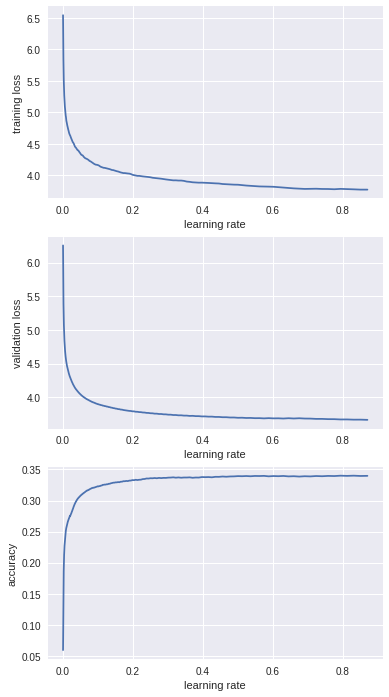

In [0]:
learn.sched.plot()

In [0]:
lr=0.8
lrs = lr

In [0]:
learn.clip=0.12
#0.12

In [0]:
learn.fit(lr, 1, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy   
    0      5.328877   4.258953   0.290936  
    1      4.661275   3.826662   0.342391  
    2      4.315868   3.713889   0.33358   
    3      4.098015   3.634999   0.347328  
    4      3.958925   3.609187   0.35479   
    5      3.848412   3.590092   0.353618  
    6      3.765895   3.583676   0.352134  
    7      3.702737   3.591091   0.35061   
    8      3.656861   3.588004   0.351935  
    9      3.632358   3.591462   0.35355   


[array([3.59146]), 0.3535502986795098]

In [0]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

## Classifier tokens

In [0]:
chunksize=24000

re1 = re.compile(r'  +')

In [0]:
df_trn = pd.read_csv(DATA_PATH+'/ULMFiT/tass_clas/train.csv', header=None, chunksize=chunksize)
df_tst = pd.read_csv(DATA_PATH+'/ULMFiT/tass_clas/validation.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(DATA_PATH+'/ULMFiT/tass_clas/test.csv', header=None, chunksize=chunksize)

In [0]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

In [0]:
np.save(DATA_PATH+'/ULMFiT/tass_clas/tok_trn.npy', tok_trn)
np.save(DATA_PATH+'/ULMFiT/tass_clas/tok_val.npy', tok_val)
np.save(DATA_PATH+'/ULMFiT/tass_clas/tok_tst.npy', tok_tst)

In [0]:
np.save(DATA_PATH+'/ULMFiT/tass_clas/trn_labels.npy', trn_labels)
np.save(DATA_PATH+'/ULMFiT/tass_clas/val_labels.npy', val_labels)
np.save(DATA_PATH+'/ULMFiT/tass_clas/tst_labels.npy', tst_labels)

In [0]:
tok_trn = np.load(DATA_PATH+'/ULMFiT/tass_clas/tok_trn.npy')
tok_val = np.load(DATA_PATH+'/ULMFiT/tass_clas/tok_val.npy')
tok_tst = np.load(DATA_PATH+'/ULMFiT/tass_clas/tok_tst.npy')

In [0]:
itos = pickle.load(open(DATA_PATH+'/ULMFiT/tass_lm/itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

579

In [0]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [0]:
np.save(DATA_PATH+'/ULMFiT/tass_clas/trn_ids.npy', trn_clas)
np.save(DATA_PATH+'/ULMFiT/tass_clas/val_ids.npy', val_clas)
np.save(DATA_PATH+'/ULMFiT/tass_clas/tst_ids.npy', tst_clas)

## Classifier

Parameters here were obtained from imdb notebook from fastai

In [0]:
trn_clas = np.load(DATA_PATH+'/ULMFiT/tass_clas/trn_ids.npy')
val_clas = np.load(DATA_PATH+'/ULMFiT/tass_clas/val_ids.npy')

In [0]:
trn_labels = np.squeeze(np.load(DATA_PATH+'/ULMFiT/tass_clas/trn_labels.npy'))
val_labels = np.squeeze(np.load(DATA_PATH+'/ULMFiT/tass_clas/val_labels.npy'))

In [0]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 8

In [0]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [0]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(DATA_PATH+'/ULMFiT/tass_lm', trn_dl, val_dl)

In [0]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8

In [0]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [0]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [0]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [0]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [0]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [0]:
#wd = 1e-7
learn.load_encoder('lm1_enc')

In [0]:
learn.freeze_to(-1)

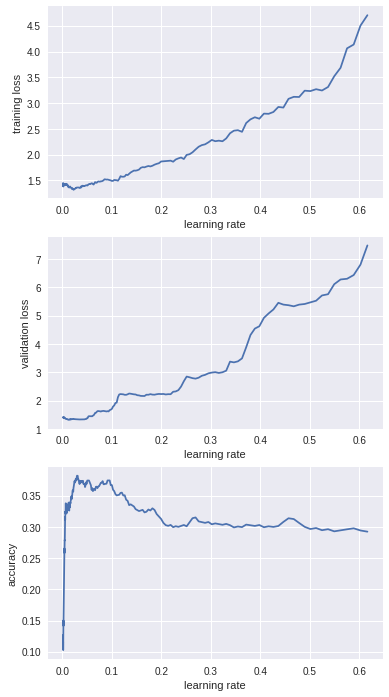

In [0]:
learn.lr_find2(start_lr=1e-3,end_lr=1, num_it=300)
learn.sched.plot()

In [0]:
lr=0.021
lrs = lr

In [0]:
learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr_beta=(10,10,0.95,0.85))#(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy   
    0      1.309872   1.207015   0.47473   
    1      1.321785   1.220877   0.505126  
    2      1.284004   1.273224   0.459442  
    3      1.335339   1.230864   0.428867  
    4      1.290872   1.507047   0.424371  
    5      1.295574   1.487655   0.444155  
    6      1.281861   1.717744   0.411331  
    7      1.325072   1.57302    0.395144  
    8      1.343458   1.258557   0.396313  
    9      1.326665   1.207835   0.509353  
    10     1.313089   1.188083   0.51295   
    11     1.310011   1.20855    0.446673  
    12     1.317976   1.170053   0.494784  
    13     1.318494   1.178976   0.496313  
    14     1.264576   1.21874    0.443255  
    15     1.266333   1.155264   0.47545   
    16     1.244849   1.194178   0.452248  
    17     1.274019   1.184626   0.474281  
    18     1.292096   1.17566    0.481025  
    19     1.244628   1.170011   0.515647  


[array([1.17001]), 0.5156474822073531]

In [0]:
learn.save('clas2_0')

In [0]:
learn.load('clas2_0')

In [0]:
learn.freeze_to(-2)

In [0]:
learn.fit(lrs, 1, wds=wd, cycle_len=10, use_clr_beta=(10,10,0.95,0.85))#(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy   
    0      1.279943   1.223583   0.454047  
    1      1.288398   1.516485   0.438759  
    2      1.311794   1.797801   0.368435  
    3      1.296755   1.189621   0.451169  
    4      1.298521   1.153579   0.488669  
    5      1.311977   8.500665   0.542446  
    6      1.22738    1.275377   0.548022  
    7      1.267464   2.246823   0.481475  
    8      1.257963   1.147844   0.572752  
    9      1.242986   1.116019   0.540378  


[array([1.11602]), 0.5403776980346913]

In [0]:
learn.save('clas2_1')

In [0]:
learn.load('clas2_1')

In [0]:
learn.unfreeze()

In [0]:
learn.fit(lr, 1, cycle_len=10, use_clr_beta=(10,10,0.95,0.85), best_save_name='clas2')

epoch      trn_loss   val_loss   accuracy   
    0      1.357756   1.251803   0.395144  
    1      1.306179   1.239467   0.395144  
    2      1.288146   1.243849   0.345953  
    3      1.330437   1.250905   0.395144  
    4      1.314199   1.259044   0.395144  
    5      1.237224   1.279584   0.395144  
    6      1.313935   1.257019   0.395144  
    7      1.277608   1.248105   0.395144  
    8      1.306282   1.23458    0.395144  
    9      1.292859   1.239805   0.395144  


[array([1.2398]), 0.395143885085051]

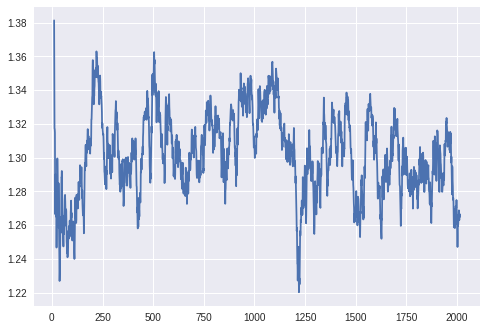

In [0]:
learn.sched.plot_loss()

## Check F1 score

We load the model with the corresponding weights and parameters

In [0]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [ ]:
# load test set tokens
tok_tst= np.load(DATA_PATH+'/ULMFiT/tass_clas/tok_tst.npy')

# load classification model weights
learn.load('clas2')
m = learn.model

# set batch size to 1
m[0].bs=1

i = 0
results = []
while i < len(tok_tst):
    sen = ' '.join(tok_tst[i])
    i+=1
    m.eval()
    # reset hidden state
    m.reset()
    idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
    idxs = np.transpose(idxs)
    # get predictions from model
    p = m(VV(idxs))
    print(sen + ': ' + str(to_np(torch.topk(p[0],1)[1])[0]))
    # append classification to list of results for validation
    results.append(torch.topk(p[0],1)[1].data.tolist()[0])

In [0]:
preds = np.asarray(results)

In [0]:
from sklearn.metrics import *
# f1 score for all four classes
print(f1_score(tst_labels, preds, average='macro'))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.2346865919468659